In [1]:
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [2]:
dataset_path = "./face-mask-detection"
batch_size = 64
num_classes = 3

In [3]:
print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")

torch.cuda.is_available(): False


In [4]:
from masks_utils import generate_box, generate_label, generate_target

In [5]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs_dir_path = os.path.join(dataset_path, "images")
        self.annotation_dir_path = os.path.join(dataset_path, "annotations")
        self.num_imgs = len(os.listdir(self.imgs_dir_path))

    def __getitem__(self, idx):
        # === trick to make dataset iterable
        if idx >= len(self):
            raise IndexError

        # load images ad masks
        file_image = "maksssksksss" + str(idx) + ".png"
        file_label = "maksssksksss" + str(idx) + ".xml"
        img_path = os.path.join(self.imgs_dir_path, file_image)
        label_path = os.path.join(self.annotation_dir_path, file_label)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        # Generate Label
        target = generate_target(idx, label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return self.num_imgs

In [6]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


dataset = MaskDataset(dataset_path, data_transform)

##  Defining the train/test data

In [7]:
train_num = int(len(dataset) / 10 * 9)
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_num, len(dataset) - train_num], generator=torch.Generator().manual_seed(42)
)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=(lambda batch: tuple(zip(*batch))))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=(lambda batch: tuple(zip(*batch))))

### Display random images from the training data

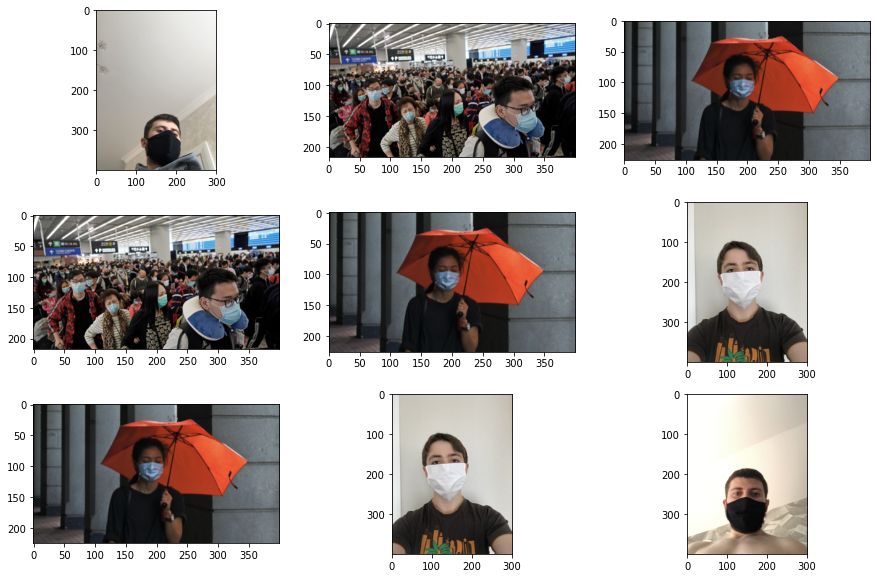

In [9]:
import numpy as np
import matplotlib.pyplot as plt
images = next(iter(train_loader))[0]
f, axarr = plt.subplots(3,3, figsize=(15,10))


for i in [0,1,2]:
    axarr[i,0].imshow(images[i].permute(1,2,0))
    axarr[i,1].imshow(images[i+1].permute(1,2,0))
    axarr[i,2].imshow(images[i+2].permute(1,2,0))


## Dataset dimensions exploration 

#### TODO: Replace this in dimensions check 

In [10]:
raw_data = []
for img, annotation in dataset:
    raw_data.append([img.shape, annotation])

im_w_list = []
im_h_list = []
num_boxes = []
labels = []
for img_shape, annotation in raw_data:
    im_w_list.append(img_shape[2])
    im_h_list.append(img_shape[1])
    num_boxes.append(annotation["boxes"].shape[0])
    labels += annotation["labels"].tolist()

import numpy as np

im_w_list = np.array(im_w_list)
im_h_list = np.array(im_h_list)
num_boxes = np.array(num_boxes)
labels = np.array(labels)

# in 603- we have 115 masks
# in 15- we have a small image (>3sigma)
print(f"Mean image width: {np.mean(im_w_list)}; Image width std: {np.std(im_w_list)}")
print(f"Mean image height: {np.mean(im_h_list)}; Image height std: {np.std(im_h_list)}")
print(f"Mean num of bbox: {np.mean(num_boxes)}; Num of bbox std: {np.std(num_boxes)=}")
hist, _ = np.histogram(labels, bins=3)
print(f"{hist=}")

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Mean image width: 370.5896834701055; Image width std: 56.19108235722637
Mean image height: 309.28956623681125; Image height std: 74.43117214603987
Mean num of bbox: 4.773739742086753; Num of bbox std: np.std(num_boxes)=7.389778734329457
hist=array([ 717, 3232,  123])


In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


### Loading a pre-trained model 

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
load_model_path = './model_epoch_17_loss_64.08599090576172.ckpt'
checkpoint = torch.load(load_model_path, map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch_ind = checkpoint["epoch_ind"]

In [11]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

###  Let's do a sample prediction

  0%|                                                                                                                                                                                                                                                                                             | 0/2 [00:00<?, ?it/s]/Users/itaygabbay/.virtualenvs/mlchecks/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Prediction


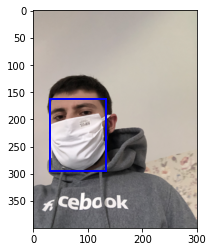

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 1/2 [14:48<14:48, 888.56s/it]

Prediction


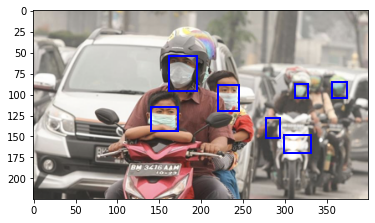

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [18:53<00:00, 566.90s/it]


In [15]:
from tqdm import tqdm
from masks_utils import plot_image
for imgs, annotations in tqdm(test_loader):
    imgs = list(img.to(device) for img in imgs)
    preds = model(imgs)

    print("Prediction")
    plot_image(imgs[0], preds[0])

## Using deepchecks to validate the model

### Implementing formatting functions for the labels and predictions

In [12]:
def label_transformer(annotation_dict_tuple):
    return_list = []
    for annotation_dict in annotation_dict_tuple:
        x1y1x2y2_tensor = annotation_dict["boxes"]
        xy_tensor = x1y1x2y2_tensor[:, :2]
        wh_tensor = x1y1x2y2_tensor[:, 2:4] - x1y1x2y2_tensor[:, :2]

        label_tensor = annotation_dict["labels"].reshape(-1, 1)

        xywh_label_tensor = torch.hstack([label_tensor, xy_tensor, wh_tensor])
        
        return_list.append(xywh_label_tensor)

    return return_list


def prediction_extract(annotation_dict_list):
    list_corrected_predictions = []
    for annotation_dict in annotation_dict_list:

        x1y1x2y2_tensor = annotation_dict["boxes"]
        xy_tensor = x1y1x2y2_tensor[:, :2]
        wh_tensor = x1y1x2y2_tensor[:, 2:4] - x1y1x2y2_tensor[:, :2]

        label_tensor = annotation_dict["labels"].reshape(-1, 1)

        confidence_tensor = annotation_dict["scores"].reshape(-1, 1)

        xywh_label_conf_tensor = torch.hstack([xy_tensor, wh_tensor, confidence_tensor, label_tensor])
        
        list_corrected_predictions.append(xywh_label_conf_tensor)

    return list_corrected_predictions

### Creating the datasets

In [13]:
from deepchecks.vision import VisionDataset
from deepchecks.vision.utils.detection_formatters import DetectionLabelFormatter, DetectionPredictionFormatter
label_formatter = DetectionLabelFormatter(label_transformer)
prediction_formatter = DetectionPredictionFormatter(prediction_extract)

ds_train = VisionDataset(train_loader, num_classes=3, label_transformer=label_formatter)
ds_test = VisionDataset(test_loader, num_classes=3, label_transformer=label_formatter)

### We can see the model detects faces correctly. However we need a deeper investigation

In [17]:
from performance_report import MeanAveragePrecisionReport, MeanAverageRecallReport

In [18]:
MeanAveragePrecisionReport(prediction_formatter).run(ds_test, model)

,Area size,mAP(COCO challenge) (%),AP@.50 (%),AP@.75 (%)
0,All,34.90,55.70,37.40
1,Small (area<32^2),15.60,30.40,17.90
2,Medium (32^2<area<96^2),38.70,60.10,42.70
3,Large (area<96^2),50.90,92.60,53.40


In [19]:
MeanAverageRecallReport(prediction_formatter).run(ds_test, model)

,Area size,AR@100 (%),AR@1 (%),AR@10 (%)
0,All,45.90,11.20,26.40
1,Small (area<32^2),25.00,5.40,12.60
2,Medium (32^2<area<96^2),49.30,12.40,23.20
3,Large (area<96^2),62.00,20.40,31.20
